In [2]:
import os
import sys

# os.chdir('../')
sys.path.append(os.getcwd())

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from scipy.stats import fisher_exact, chi2_contingency
from sklearn.manifold import TSNE, MDS
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, PrecisionRecallDisplay
from multipy.fwer import sidak, hochberg
from xgboost import XGBClassifier
import random

from utils.viz_utils import plot_usage_matrix_pca, plot_boxplots_for_usage_matrix, _plot_feature_importance, plot_v_usage_hist, \
                                plot_cluster_map, significant_clones_distribution, plot_results_for_hla_class, plot_generated_to_real_distribution, \
                            plot_olga_cleanup_data, plot_clusters_of_clonotypes, plot_cooccurence_heatmap_with_epitopes_labeling, plot_waterfall_by_column, \
                            plot_feature_importances, plot_volcano, plot_clonotype_clustering_with_epitope_labeling
from utils.ml_utils import get_parameters, prepare_data, evaluate_models, split_data_by_batch, cross_validation_between_batches, make_hla_predictor
from utils.data_utils import prepare_run_column
from utils.stats_utils import evaluate_anova_testing, evaluate_mannwhitneyu_testing, get_top_changed_clonotypes
from utils.clustering_utils import seqs2hamming, check_significant_epitopes_for_cluster, get_most_frequent_cluster_by_vdjdb_occurence, \
                                check_significant_epitopes_for_all_clusters, read_association_data
from utils.weblogo_utils import create_web_logo
from source.alpha_beta_paired_clones_search import make_metaclone_cm


import warnings
warnings.filterwarnings('ignore')


import importlib
imported_module = importlib.import_module("utils.stats_utils")
importlib.reload(imported_module)

<module 'utils.stats_utils' from '/home/evlasova/tcr-covid-classifier/utils/stats_utils.py'>

# Reading UMs

In [3]:
norm_um_joint = pd.read_csv('data/normalized_usage_matrix_joint_v.csv').drop(columns=['Unnamed: 0']).fillna(0)
stand_um_joint = pd.read_csv('data/standardized_usage_matrix_joint_v.csv').drop(columns=['Unnamed: 0']).fillna(0)

In [4]:
norm_um_joint['project'] = norm_um_joint['project'].apply(lambda x: x.replace('_DNA', '').split('_')[-1])

In [5]:
stand_um_joint['project'] = stand_um_joint['project'].apply(lambda x: x.replace('_DNA', '').split('_')[-1])

In [6]:
stand_um_joint

,run,project,covid,TRBV13,TRBV6-4,TRBV6-7,TRBV5-4,TRBV7-1,TRBV6-8,TRBV16,...,TRBV7-7,TRBV25-1,TRBV21-1,TRBV18,TRBV10-1,TRBV1,TRBV8-2,TRBV5-2,TRBV22-1,TRBV26
0,050002290808_S117_L002.clonotypes.TRB.txt,NovaSeq2,covid,0.003474,0.014043,0.001055,0.023937,0.000008,0.000661,0.000450,...,0.005438,0.003233,0.014215,0.027352,0.007841,0.001079,1.696294e-06,0.000003,0.000009,6.917419e-07
1,050002630808_S113_L002.clonotypes.TRB.txt,NovaSeq2,covid,0.007076,0.021841,0.001130,0.022548,0.000008,0.000710,0.000484,...,0.007519,0.010263,0.009868,0.029526,0.016554,0.001162,1.827189e-06,0.000003,0.000010,7.451205e-07
2,050003120808_S112_L002.clonotypes.TRB.txt,NovaSeq2,covid,0.006501,0.012496,0.001329,0.018439,0.000007,0.001137,0.000444,...,0.001922,0.006333,0.027440,0.038011,0.002849,0.001065,1.674763e-06,0.000003,0.000009,6.829615e-07
3,050003130808_S114_L002.clonotypes.TRB.txt,NovaSeq2,covid,0.006554,0.010890,0.001096,0.019498,0.000007,0.000872,0.000440,...,0.007736,0.012005,0.020345,0.035833,0.009140,0.001056,1.660397e-06,0.000003,0.000009,6.771032e-07
4,050003450808_S118_L002.clonotypes.TRB.txt,NovaSeq2,covid,0.005554,0.007503,0.001363,0.028087,0.000007,0.000898,0.000445,...,0.003293,0.004600,0.018388,0.010175,0.003035,0.001068,1.678981e-06,0.000003,0.000009,6.846817e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,Keck0116_MC1.txt,KECK,healthy,0.005532,0.002471,0.001099,0.020060,0.000010,0.000807,0.000402,...,0.003144,0.005968,0.012771,0.005411,0.005918,0.001757,1.386017e-06,0.000003,0.000007,6.137553e-07
3212,Keck0117_MC1.txt,KECK,healthy,0.009565,0.014078,0.001816,0.024067,0.000006,0.000964,0.000557,...,0.006522,0.006600,0.014357,0.023070,0.008981,0.001154,1.544601e-06,0.000001,0.000005,6.819803e-07
3213,Keck0118_MC1.txt,KECK,healthy,0.007088,0.017838,0.001670,0.022876,0.000010,0.001317,0.000534,...,0.005692,0.013521,0.011688,0.005806,0.003133,0.001475,2.012325e-06,0.000004,0.000007,6.868246e-07
3214,Keck0119_MC1.txt,KECK,healthy,0.004732,0.002107,0.000908,0.022094,0.000009,0.000236,0.000556,...,0.005394,0.016580,0.009938,0.017636,0.011721,0.001100,6.636811e-07,0.000004,0.000011,6.426646e-07


In [7]:
stand_um_joint[stand_um_joint.project.str.lower().str.contains('nova')].project.value_counts().sum()

1225

# Analysis of Adaptive found biomarkers

In [8]:
all_adaptive_cm = pd.read_csv('data/sign_clone_matrix_joint_adaptive_based.csv').drop(columns=['Unnamed: 0'])

In [9]:
all_adaptive_cm.head()

,CASSLGGSTDTQYF,CASSLAGTDTQYF,CASSLGGGNQPQHF,CASSLGGGTDTQYF,CASSLGQGNYGYTF,CASSLAGGSYNEQFF,CASSLAGGETQYF,CASSLGGSYNEQFF,CASSLGQGNSPLHF,CASSPGQGNYGYTF,...,CASSLRATQYF,CASSQAGTYYGYTF,CASSYSGAGGETQYF,CASSYSGGINQPQHF,CASSYSGQGYEKLFF,CASSLGMGSYNEQFF,CASSQDLVGETQYF,CASSYSGGITDTQYF,CASSLGTKNSPLHF,run
0,0,0,3,0,1,2,0,1,1,0,...,0,0,0,0,2,0,0,0,0,330000810808_S11_L001.clonotypes.TRB.txt
1,0,1,0,0,2,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,340003690808_S19_L001.clonotypes.TRB.txt
2,0,0,3,0,2,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,770104420808_S61_L001.clonotypes.TRB.txt
3,0,1,2,0,4,1,0,0,1,3,...,0,0,0,1,0,0,0,0,1,500003950808_S31_L001.clonotypes.TRB.txt
4,0,1,1,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,260002830808_S80_L001.clonotypes.TRB.txt


In [10]:
fold_change_data_adaptive = get_top_changed_clonotypes(clonotype_matrix=all_adaptive_cm[~all_adaptive_cm.run.str.contains('clonotypes')],
                           desc=stand_um_joint, 
                           pvals=pd.read_csv('data/covid_significant_clone_pvals_adaptive.csv').drop(columns=['Unnamed: 0']), 
                           run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_joint.csv'),
                           healthy_col='covid', 
                           healthy_label='healthy')
fold_change_data_adaptive

v


,clone,pval,count_of_ways_h,count_of_ways_i,fold_change,log_fold_change
0,CASSLGGSTDTQYF,5.807251e-94,0.045236,0.120010,2.652981,1.407614
1,CASSLAGTDTQYF,2.115642e-18,0.040330,0.089208,2.211969,1.145331
2,CASSLGGGNQPQHF,1.989620e-74,0.053762,0.119455,2.221928,1.151812
3,CASSLGGGTDTQYF,1.896342e-65,0.043779,0.109548,2.502309,1.323260
4,CASSLGQGNYGYTF,4.445957e-49,0.036733,0.081823,2.227512,1.155433
...,...,...,...,...,...,...
17180,CASSYSGQGYEKLFF,1.215402e-20,0.000296,0.002075,7.005120,2.808410
17181,CASSLGMGSYNEQFF,2.654297e-31,0.005938,0.018586,3.129868,1.646102
17182,CASSQDLVGETQYF,3.176776e-16,0.000398,0.002272,5.709946,2.513477
17183,CASSYSGGITDTQYF,3.275740e-24,0.001191,0.004611,3.871417,1.952862


In [11]:
fold_change_data_adaptive[fold_change_data_adaptive.log_fold_change > 2.25]

,clone,pval,count_of_ways_h,count_of_ways_i,fold_change,log_fold_change
403,CASSYSGLAGVYNEQFF,3.512117e-74,0.000490,0.007323,14.949902,3.902064
778,CSARSGHEQYF,6.738272e-131,0.001373,0.016213,11.809513,3.561878
1127,CASSQDLGQPQHF,3.357477e-91,0.003265,0.017182,5.262965,2.395876
1460,CSASSGHEQYF,1.284266e-133,0.001049,0.013937,13.280313,3.731217
1501,CASSYSRTGGGYGYTF,6.997536e-89,0.000104,0.005445,52.329702,5.709558
...,...,...,...,...,...,...
17172,CASSYSRISGNTIYF,7.945274e-24,0.000320,0.002892,9.028585,3.174500
17178,CASSYSGAGGETQYF,6.262340e-19,0.000325,0.002016,6.204651,2.633350
17179,CASSYSGGINQPQHF,1.315399e-25,0.000574,0.003539,6.169133,2.625068
17180,CASSYSGQGYEKLFF,1.215402e-20,0.000296,0.002075,7.005120,2.808410


In [12]:
selected_clones = fold_change_data_adaptive[fold_change_data_adaptive.log_fold_change > 2.25].clone

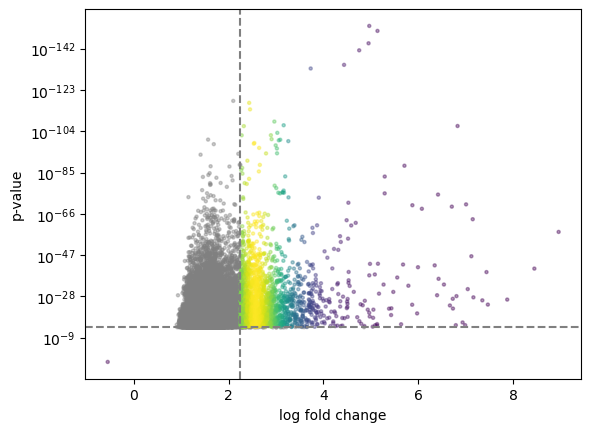

In [13]:
plot_volcano(fold_change_data_adaptive, pval_threshold=1e-14, fold_change_threshold=2.25)

In [14]:
selected_clones.shape

(2066,)

In [15]:
all_adaptive_cm[['run'] + list(selected_clones)].to_csv('data/sign_clone_matrix_fold_change_adaptive.csv')

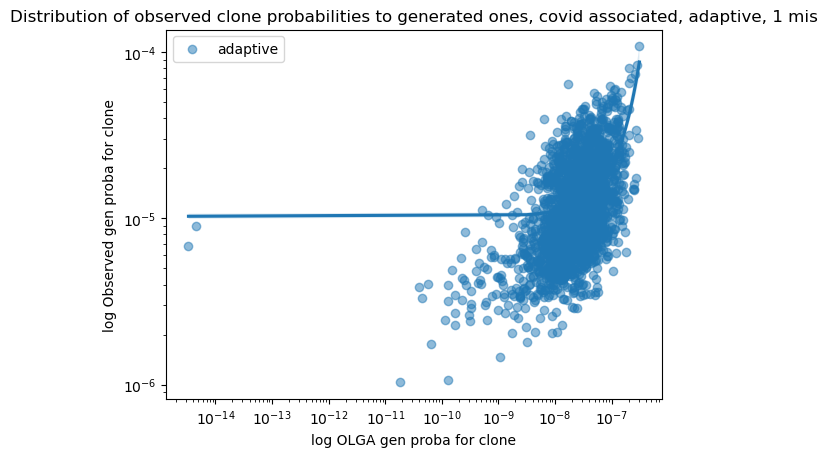

In [16]:
probas_adaptive = plot_generated_to_real_distribution(pgen_paths=['data/covid_adaptive_pgen.csv'], 
                                    cm_paths=['data/sign_clone_matrix_fold_change.csv'], 
                                    desc='covid associated, adaptive, 1 mis', 
                                    run_to_number_of_clones_path='data/run_to_number_of_clones_adaptive.csv', 
                                    labels=['adaptive'],
                                    make_bool_features=False)['adaptive']

In [17]:
vdjdb = pd.read_csv('data/vdjdb.txt', sep='\t')

In [70]:
res_adaptive = seqs2hamming(selected_clones, threshold=1, viz_method='graphopt')

In [71]:
res_adaptive

,cdr3,cluster,x,y,cluster_size,x_mean,y_mean
0,CASSYSGLAGVYNEQFF,0,391.631152,-539.601882,32,316.491623,-419.910811
1,CASSYSGLAGIYNEQFF,0,408.633286,-532.623208,32,316.491623,-419.910811
2,CASSYSPLAGVYNEQFF,0,371.020741,-484.561253,32,316.491623,-419.910811
3,CASSYSGLAGAYNEQFF,0,417.384332,-560.583900,32,316.491623,-419.910811
4,CASSYSSLAGVYNEQFF,0,393.387839,-497.699861,32,316.491623,-419.910811
...,...,...,...,...,...,...,...
2061,CASSQVLASYEQYF,226,296.767974,-799.474639,1,296.767974,-799.474639
2062,CSGQTGVNQPQHF,227,564.796830,-324.200277,1,564.796830,-324.200277
2063,CASSQEISSYEQYF,228,-39.679606,743.662911,1,-39.679606,743.662911
2064,CSAQSGVNQPQHF,229,20.829958,35.517847,1,20.829958,35.517847


In [20]:
adaptive_cluster_to_epi = read_association_data('figures/associations/adaptive_TRB_sign_assoc_with_max_enrichment.csv')

# Making FMBA based classifier

In [21]:
fmba_not_nan_hla = pd.read_csv('data/preprocessed_fmba_metadata_beta.csv')

In [22]:
fmba_not_nan_hla = fmba_not_nan_hla[fmba_not_nan_hla.COVID_status != 'unknown']

In [23]:
good_fmba_samples = fmba_not_nan_hla.run

In [24]:
good_fmba_samples

0       050002290808_S117_L002.clonotypes.TRB.txt
1       050002630808_S113_L002.clonotypes.TRB.txt
2       050003120808_S112_L002.clonotypes.TRB.txt
3       050003130808_S114_L002.clonotypes.TRB.txt
4       050003450808_S118_L002.clonotypes.TRB.txt
                          ...                    
1220       p18_72_DNA_S88_L002.clonotypes.TRB.txt
1221       p18_73_DNA_S89_L002.clonotypes.TRB.txt
1222       p18_74_DNA_S90_L002.clonotypes.TRB.txt
1223       p18_75_DNA_S91_L002.clonotypes.TRB.txt
1224       p18_76_DNA_S92_L002.clonotypes.TRB.txt
Name: run, Length: 1225, dtype: object

In [25]:
stand_um_joint['platform'] = stand_um_joint.run.apply(lambda x: 'fmba' if 'TRB' in x else 'adaptive')

In [26]:
stand_um_joint['platform'].value_counts()

adaptive    1991
fmba        1225
Name: platform, dtype: int64

In [27]:
pd.read_csv('data/sign_clone_matrix_joint_fmba_based.csv')

,Unnamed: 0,CASAPGGSYEQYF,CASGLGGNQPQHF,CASGLSGGNQPQHF,CASGQGGYEQYF,CASIPGGSYEQYF,CASKLGTSYEQYF,CASKLSGGNQPQHF,CASKPGGSYEQYF,CASLPGGSYEQYF,...,CSARSGHEQYV,CSARSSYEQYF,CSARTSYEQYF,CSASDRGYEQYF,CSASGGGYEQYF,CSASSGHEQYF,CSASSSYEQYF,CSATSGHEQYF,RASSLGTSYEQYF,run
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,260002830808_S80_L001.clonotypes.TRB.txt
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,780003310808_S68_L001.clonotypes.TRB.txt
2,2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,770104420808_S61_L001.clonotypes.TRB.txt
3,3,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,2,0,2,0,360001390808_S117_L002.clonotypes.TRB.txt
4,4,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,260002150808_S40_L001.clonotypes.TRB.txt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,3211,5,5,4,7,5,3,3,5,4,...,0,10,14,5,3,0,5,0,3,HIP17577.txt
3212,3212,1,6,4,4,1,0,3,3,2,...,0,2,3,5,5,1,3,1,0,HIP14213.txt
3213,3213,4,12,3,9,4,2,1,5,5,...,0,12,11,3,3,0,10,0,2,HIP17585.txt
3214,3214,2,6,1,6,0,1,0,0,1,...,0,4,1,1,8,1,7,0,0,HIP17657.txt


In [28]:
data_fmba = prepare_data(run_to_number_of_clones_path = 'data/run_to_number_of_clones_joint.csv',
                 desc_path='data/standardized_usage_matrix_joint_v.csv',
                 clonotype_matrix_path='data/sign_clone_matrix_joint_fmba_based.csv',
                 hla_keys_path=None,
                 make_freq=True,
                 use_hla_clones=False,
                 use_hla_bool=False,
                 make_all_features_bool=True,
                 use_standardization=True,
                 raw_target_column='covid',
                 raw_target_clumn_success_label='covid',
                 final_target_column='covid',
                 metadata_columns=[])
fmba_good_beta_biomarkers_data = [x for x in pd.read_csv('data/sign_clone_matrix_joint_fmba_based.csv').columns if x.startswith('CAS')]
data_fmba = data_fmba[fmba_good_beta_biomarkers_data + ['covid']]
data_fmba['folder'] = stand_um_joint['project']
data_fmba['platform'] = stand_um_joint['platform']
data_fmba['run'] = stand_um_joint['run']

In [29]:
data_fmba = data_fmba[(data_fmba.run.isin(good_fmba_samples)) | (data_fmba.platform == 'adaptive')].drop(columns=['run', 'platform'])

In [30]:
data_fmba

,CASAPGGSYEQYF,CASGLGGNQPQHF,CASGLSGGNQPQHF,CASGQGGYEQYF,CASIPGGSYEQYF,CASKLGTSYEQYF,CASKLSGGNQPQHF,CASKPGGSYEQYF,CASLPGGSYEQYF,CASNPGGSYEQYF,...,CASSYGVGYEQYF,CASSYGYEQYF,CASSYRGAFGYTF,CASSYSGGSYEQYF,CASSYSYEQYF,CASSYTSYEQYF,CASTLGGSYEQYF,CASTPGGAGYTF,covid,folder
0,-1.136045,0.492604,-1.005613,-1.409281,-1.13461,-0.888622,-0.913548,-1.166719,-1.100831,-1.237854,...,-1.342160,0.205246,-0.468087,0.465122,0.174468,0.480384,0.635898,-0.654751,1,NovaSeq2
1,-1.136045,-2.030029,-1.005613,0.709582,-1.13461,-0.888622,-0.913548,-1.166719,-1.100831,-1.237854,...,0.745068,0.205246,2.136355,-2.149972,0.174468,-2.081666,-1.572578,1.527299,1,NovaSeq2
2,0.880247,0.492604,-1.005613,-1.409281,0.88136,-0.888622,-0.913548,0.857104,0.908404,0.807849,...,0.745068,0.205246,-0.468087,-2.149972,0.174468,0.480384,-1.572578,-0.654751,1,NovaSeq2
3,-1.136045,-2.030029,-1.005613,-1.409281,-1.13461,-0.888622,-0.913548,-1.166719,-1.100831,-1.237854,...,-1.342160,0.205246,-0.468087,0.465122,0.174468,-2.081666,-1.572578,-0.654751,1,NovaSeq2
4,-1.136045,-2.030029,-1.005613,-1.409281,-1.13461,-0.888622,-0.913548,-1.166719,-1.100831,-1.237854,...,-1.342160,-4.872213,2.136355,-2.149972,0.174468,-2.081666,0.635898,-0.654751,1,NovaSeq2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,0.880247,0.492604,-1.005613,0.709582,0.88136,1.125338,-0.913548,0.857104,0.908404,0.807849,...,0.745068,0.205246,-0.468087,0.465122,0.174468,0.480384,0.635898,1.527299,0,KECK
3212,0.880247,0.492604,0.994419,0.709582,0.88136,1.125338,1.094634,0.857104,0.908404,0.807849,...,0.745068,0.205246,2.136355,0.465122,0.174468,0.480384,0.635898,1.527299,0,KECK
3213,0.880247,0.492604,-1.005613,0.709582,0.88136,1.125338,-0.913548,0.857104,0.908404,0.807849,...,0.745068,0.205246,-0.468087,0.465122,0.174468,0.480384,0.635898,-0.654751,0,KECK
3214,0.880247,0.492604,0.994419,0.709582,0.88136,1.125338,1.094634,0.857104,0.908404,0.807849,...,0.745068,0.205246,-0.468087,0.465122,0.174468,0.480384,0.635898,1.527299,0,KECK


In [31]:
X_train_fmba, y_train_fmba, X_test_fmba, y_test_fmba = split_data_by_batch(data=data_fmba, 
                                                       test_batches=[x for x in stand_um_joint.project.unique() if 'Nova' not in x], 
                                                       y_column='covid', 
                                                       batch_column='folder')

In [32]:
fmba_clf = SVC(C=5, kernel='rbf', probability=True, random_state=42).fit(X_train_fmba, y_train_fmba)

In [33]:
y_pred_fmba = fmba_clf.predict(X_test_fmba)

In [34]:
metrics_fmba = pd.DataFrame({'f1': [round(f1_score(y_test_fmba, y_pred_fmba), 2)], 
              'precision': [round(precision_score(y_test_fmba, y_pred_fmba), 2)], 
              'recall': [round(recall_score(y_test_fmba, y_pred_fmba), 2)]})

In [35]:
fmba_cm = pd.read_csv('data/sign_clone_matrix_joint_fmba_based.csv').drop(columns=['Unnamed: 0'])
fmba_clones = fmba_cm.drop(columns=['run']).columns
res_fmba = seqs2hamming(fmba_clones, threshold=1, viz_method='drl')
metaclone_fmba_cm = make_metaclone_cm(fmba_cm, res_fmba)
metaclone_fmba_cm.to_csv('data/clone_matrix_covid_fmba_and_adaptive_metaclone.csv')

In [36]:
data_fmba_meta = prepare_data(run_to_number_of_clones_path = 'data/run_to_number_of_clones_joint.csv',
                 desc_path='data/standardized_usage_matrix_joint_v.csv',
                 clonotype_matrix_path='data/clone_matrix_covid_fmba_and_adaptive_metaclone.csv',
                 hla_keys_path=None,
                 make_freq=True,
                 use_hla_clones=False,
                 use_hla_bool=False,
                 make_all_features_bool=True,
                 use_standardization=True,
                 raw_target_column='covid',
                 raw_target_clumn_success_label='covid',
                 final_target_column='covid',
                 metadata_columns=[])
data_fmba_meta['folder'] = stand_um_joint['project']
data_fmba_meta['platform'] = stand_um_joint['platform']
data_fmba_meta['run'] = stand_um_joint['run']

In [37]:
X_train_fmba_m, y_train_fmba_m, X_test_fmba_m, y_test_fmba_m = split_data_by_batch(data=data_fmba_meta.drop(columns=['run', 'platform']), 
                                                       test_batches=[x for x in stand_um_joint.project.unique() if 'Nova' not in x], 
                                                       y_column='covid', 
                                                       batch_column='folder')

In [38]:
fmba_clf_m = SVC(C=5, kernel='rbf', probability=True, random_state=42).fit(X_train_fmba_m, y_train_fmba_m)
y_pred_fmba_m = fmba_clf_m.predict(X_test_fmba_m)

In [39]:
metrics_fmba_m = pd.DataFrame({'f1': [round(f1_score(y_test_fmba_m, y_pred_fmba_m), 2)], 
              'precision': [round(precision_score(y_test_fmba_m, y_pred_fmba_m), 2)], 
              'recall': [round(recall_score(y_test_fmba_m, y_pred_fmba_m), 2)]})

# Making Adaptive based classifier

In [40]:
data_adaptive = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_joint_50k.csv',
             desc_path='data/standardized_usage_matrix_joint_v.csv',
             clonotype_matrix_path='data/sign_clone_matrix_fold_change_adaptive.csv',
             hla_keys_path=None,
             make_freq=True,
             use_hla_clones=False,
             use_hla_bool=False,
             use_standardization=True,
             raw_target_column='covid',
             raw_target_clumn_success_label='covid',
             final_target_column='covid',
             metadata_columns=[])

data_adaptive['folder'] = stand_um_joint['project']
data_adaptive['platform'] = stand_um_joint['platform']
data_adaptive['run'] = stand_um_joint['run']

In [41]:
data_adaptive = data_adaptive[(data_adaptive.run.isin(good_fmba_samples)) | (data_adaptive.platform == 'adaptive')].drop(columns=['run', 'platform'])

In [42]:
X_train_adaptive, y_train_adaptive, X_test_adaptive, y_test_adaptive = split_data_by_batch(data=data_adaptive, 
                                                                           test_batches=[x for x in stand_um_joint.project.unique() if 'Nova' in x], 
                                                                           y_column='covid', 
                                                                           batch_column='folder')

In [43]:
adaptive_clf = SVC(C=5, kernel='rbf', probability=True, random_state=42).fit(X_train_adaptive, y_train_adaptive)

In [44]:
y_pred_adaptive = adaptive_clf.predict(X_test_adaptive)

In [45]:
metrics_adaptive = pd.DataFrame({'f1': [round(f1_score(y_test_adaptive, y_pred_adaptive), 2)], 
              'precision': [round(precision_score(y_test_adaptive, y_pred_adaptive), 2)], 
              'recall': [round(recall_score(y_test_adaptive, y_pred_adaptive), 2)]})

In [46]:
adaptive_cm = pd.read_csv('data/sign_clone_matrix_fold_change_adaptive.csv').drop(columns=['Unnamed: 0'])
adaptive_clones = adaptive_cm.drop(columns=['run']).columns
res_adaptive = seqs2hamming(adaptive_clones, threshold=1, viz_method='drl')
metaclone_adaptive_cm = make_metaclone_cm(adaptive_cm, res_adaptive)
metaclone_adaptive_cm.to_csv('data/clone_matrix_covid_fmba_and_adaptive_metaclone_adaptive_based.csv')

data_adaptive_meta = prepare_data(run_to_number_of_clones_path = 'data/run_to_number_of_clones_joint_50k.csv',
                 desc_path='data/standardized_usage_matrix_joint_v.csv',
                 clonotype_matrix_path='data/clone_matrix_covid_fmba_and_adaptive_metaclone_adaptive_based.csv',
                 hla_keys_path=None,
                 make_freq=True,
                 use_hla_clones=False,
                 use_hla_bool=False,
                 use_standardization=True,
                 raw_target_column='covid',
                 raw_target_clumn_success_label='covid',
                 final_target_column='covid',
                 metadata_columns=[])
data_adaptive_meta['folder'] = stand_um_joint['project']
data_adaptive_meta['platform'] = stand_um_joint['platform']
data_adaptive_meta['run'] = stand_um_joint['run']

X_train_adaptive_m, y_train_adaptive_m, X_test_adaptive_m, y_test_adaptive_m = split_data_by_batch(
                                                       data=data_adaptive_meta.drop(columns=['run', 'platform']), 
                                                       test_batches=[x for x in stand_um_joint.project.unique() if 'Nova' in x], 
                                                       y_column='covid', 
                                                       batch_column='folder')

adaptive_clf_m = SVC(C=5, kernel='rbf', probability=True, random_state=42).fit(X_train_adaptive_m, y_train_adaptive_m)
y_pred_adaptive_m = adaptive_clf_m.predict(X_test_adaptive_m)

metrics_adaptive_m = pd.DataFrame({'f1': [round(f1_score(y_test_adaptive_m, y_pred_adaptive_m), 2)], 
              'precision': [round(precision_score(y_test_adaptive_m, y_pred_adaptive_m), 2)], 
              'recall': [round(recall_score(y_test_adaptive_m, y_pred_adaptive_m), 2)]})

# Making joint df for metrics

In [47]:
y_test_data = {
    'fmba->adaptive': y_test_fmba,
    'adaptive->fmba': y_test_adaptive,
    # 'fmba_meta->adaptive': y_test_fmba_m,
    # 'adaptive_meta->fmba': y_test_adaptive_m,
} 
all_clfs = {
    'fmba->adaptive': fmba_clf,
    'adaptive->fmba': adaptive_clf,
    # 'fmba_meta->adaptive': fmba_clf_m,
    # 'adaptive_meta->fmba': adaptive_clf_m
} 
X_test_data = {
    'fmba->adaptive': X_test_fmba,
    'adaptive->fmba': X_test_adaptive,
    # 'fmba_meta->adaptive': X_test_fmba_m,
    # 'adaptive_meta->fmba': X_test_adaptive_m
} 

In [48]:
metrics = pd.concat([metrics_fmba, metrics_adaptive])
metrics.index = ['fmba->adaptive', 'adaptive->fmba']

In [49]:
metrics

,f1,precision,recall
fmba->adaptive,0.76,0.61,1.0
adaptive->fmba,0.82,0.69,1.0


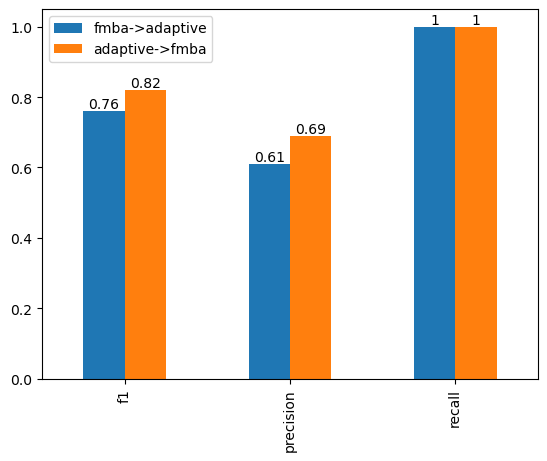

In [50]:
fig, ax = plt.subplots()
metrics.T.plot.bar(ax=ax)
for c in ax.containers:
    ax.bar_label(c, label_type='edge')

# Making joint clustering results

In [51]:
covid_clones_fmba_beta = pd.read_csv('data/significant_clone_matrix_fisher_fmba_TRB_top_500k_wo_leaks.csv').drop(columns=['Unnamed: 0']).columns[1:]

In [57]:
res_joint = seqs2hamming(list(selected_clones) + list(covid_clones_fmba_beta), threshold=1, viz_method='graphopt')

In [58]:
res_joint['platform'] = res_joint.cdr3.apply(lambda x: 'joint' if x in covid_clones_fmba_beta and x in selected_clones else ('fmba' if x in covid_clones_fmba_beta else 'adaptive'))

In [59]:
res_joint

,cdr3,cluster,x,y,cluster_size,x_mean,y_mean,platform
0,CASSYSGLAGVYNEQFF,0,-328.879755,-577.088878,32,374.717410,-263.763361,adaptive
1,CASSYSGLAGIYNEQFF,0,-334.154296,-596.467860,32,374.717410,-263.763361,adaptive
2,CASSYSPLAGVYNEQFF,0,-121.512067,-548.488067,32,374.717410,-263.763361,adaptive
3,CASSYSGLAGAYNEQFF,0,-356.197231,-578.763414,32,374.717410,-263.763361,adaptive
4,CASSYSSLAGVYNEQFF,0,-271.217158,-582.628086,32,374.717410,-263.763361,adaptive
...,...,...,...,...,...,...,...,...
2617,CSASSSYEQYF,280,-188.730755,771.122136,6,-180.722452,755.629419,fmba
2618,CSARGSYEQYF,280,-197.316248,733.749660,6,-180.722452,755.629419,fmba
2619,CSARTSYEQYF,280,-177.917074,729.880086,6,-180.722452,755.629419,fmba
2620,CSASDRGYEQYF,281,-735.215046,363.932591,1,-735.215046,363.932591,fmba


In [55]:
joint_cluster_to_epi = read_association_data('figures/associations/joint_TRB_sign_assoc_with_max_enrichment.csv')

YQDVNCTEV
MPYIFTLLL
VLLSVLQQL
RQLLFVVEV
NPANNASIV
TPINLVRDL
LPDDFTGCV
TSAMHTMLF
STSAFVETV
YLNTLTLAV
LYALVYFLH
RTIKVFTTV
TALALLLLD
RLNQLESKM
TMADLVYAL
NYMPYFFTL
VLCNSQTSL
SANNCTFEY
VFLVLWPLV
YVFCTVNAL
WLTNIFGTV
LSFKELLVY
TALALLLLD
NLLLQYGSFCTQLNRAL
NLLKDCPAV
FLNGSCGSV
LLYDANYFL
MPASWVMRI
SLIYSTAAL
VYFLQSINF
SSGDATTAY


(-1100.0, 1100.0)

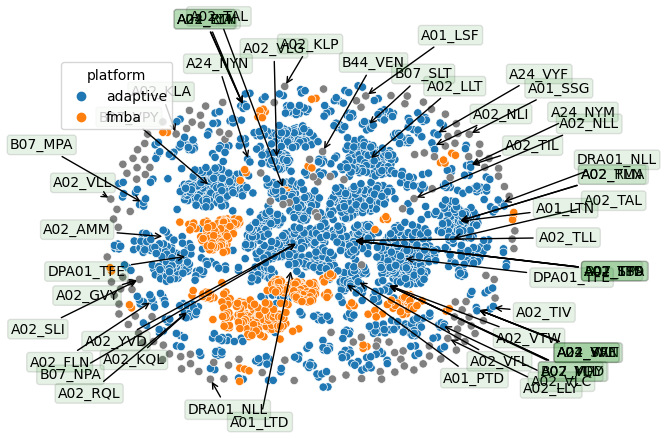

In [66]:
fig, ax = plt.subplots()
plot_clonotype_clustering_with_epitope_labeling(res_joint, 
                                                joint_cluster_to_epi, 
                                                vdjdb, 
                                                gene='TRB',
                                                color_by='platform',
                                                cluster_size_threshold=0, 
                                                dist_to_center=1050, 
                                                center_diff_threshold=100,
                                                ax=ax,
                                                species_to_plot=['SARS-CoV-2'])
ax.set_xlim(-1100, 1100)
ax.set_ylim(-1100, 1100)


# Plotting Fig 5

KLFIRQEEV
RQLLFVVEV
NPANNASIV
TIVEVQPQL
TPINLVRDL
LPDDFTGCV
TSAMHTMLF
STSAFVETV
TALALLLLD
NYMPYFFTL
SVLYYQNNV
LLTNMFTPL
RLNEVAKNL
VFLVLWPLV
AMMFTSDLA
FLPGVYSVI
NLLLQYGSFCTQLNRAL
NLLKDCPAV
NLLLQYGSFCTQLNRAL
NYNYLYRLF
YQDVNCTEV
MPYIFTLLL
VLLSVLQQL
RQLLFVVEV
NPANNASIV
TPINLVRDL
LPDDFTGCV
TSAMHTMLF
STSAFVETV
YLNTLTLAV
LYALVYFLH
RTIKVFTTV
TALALLLLD
RLNQLESKM
TMADLVYAL
NYMPYFFTL
VLCNSQTSL
SANNCTFEY
VFLVLWPLV
YVFCTVNAL
WLTNIFGTV
LSFKELLVY
TALALLLLD
NLLLQYGSFCTQLNRAL
NLLKDCPAV
FLNGSCGSV
LLYDANYFL
MPASWVMRI
SLIYSTAAL
VYFLQSINF
SSGDATTAY


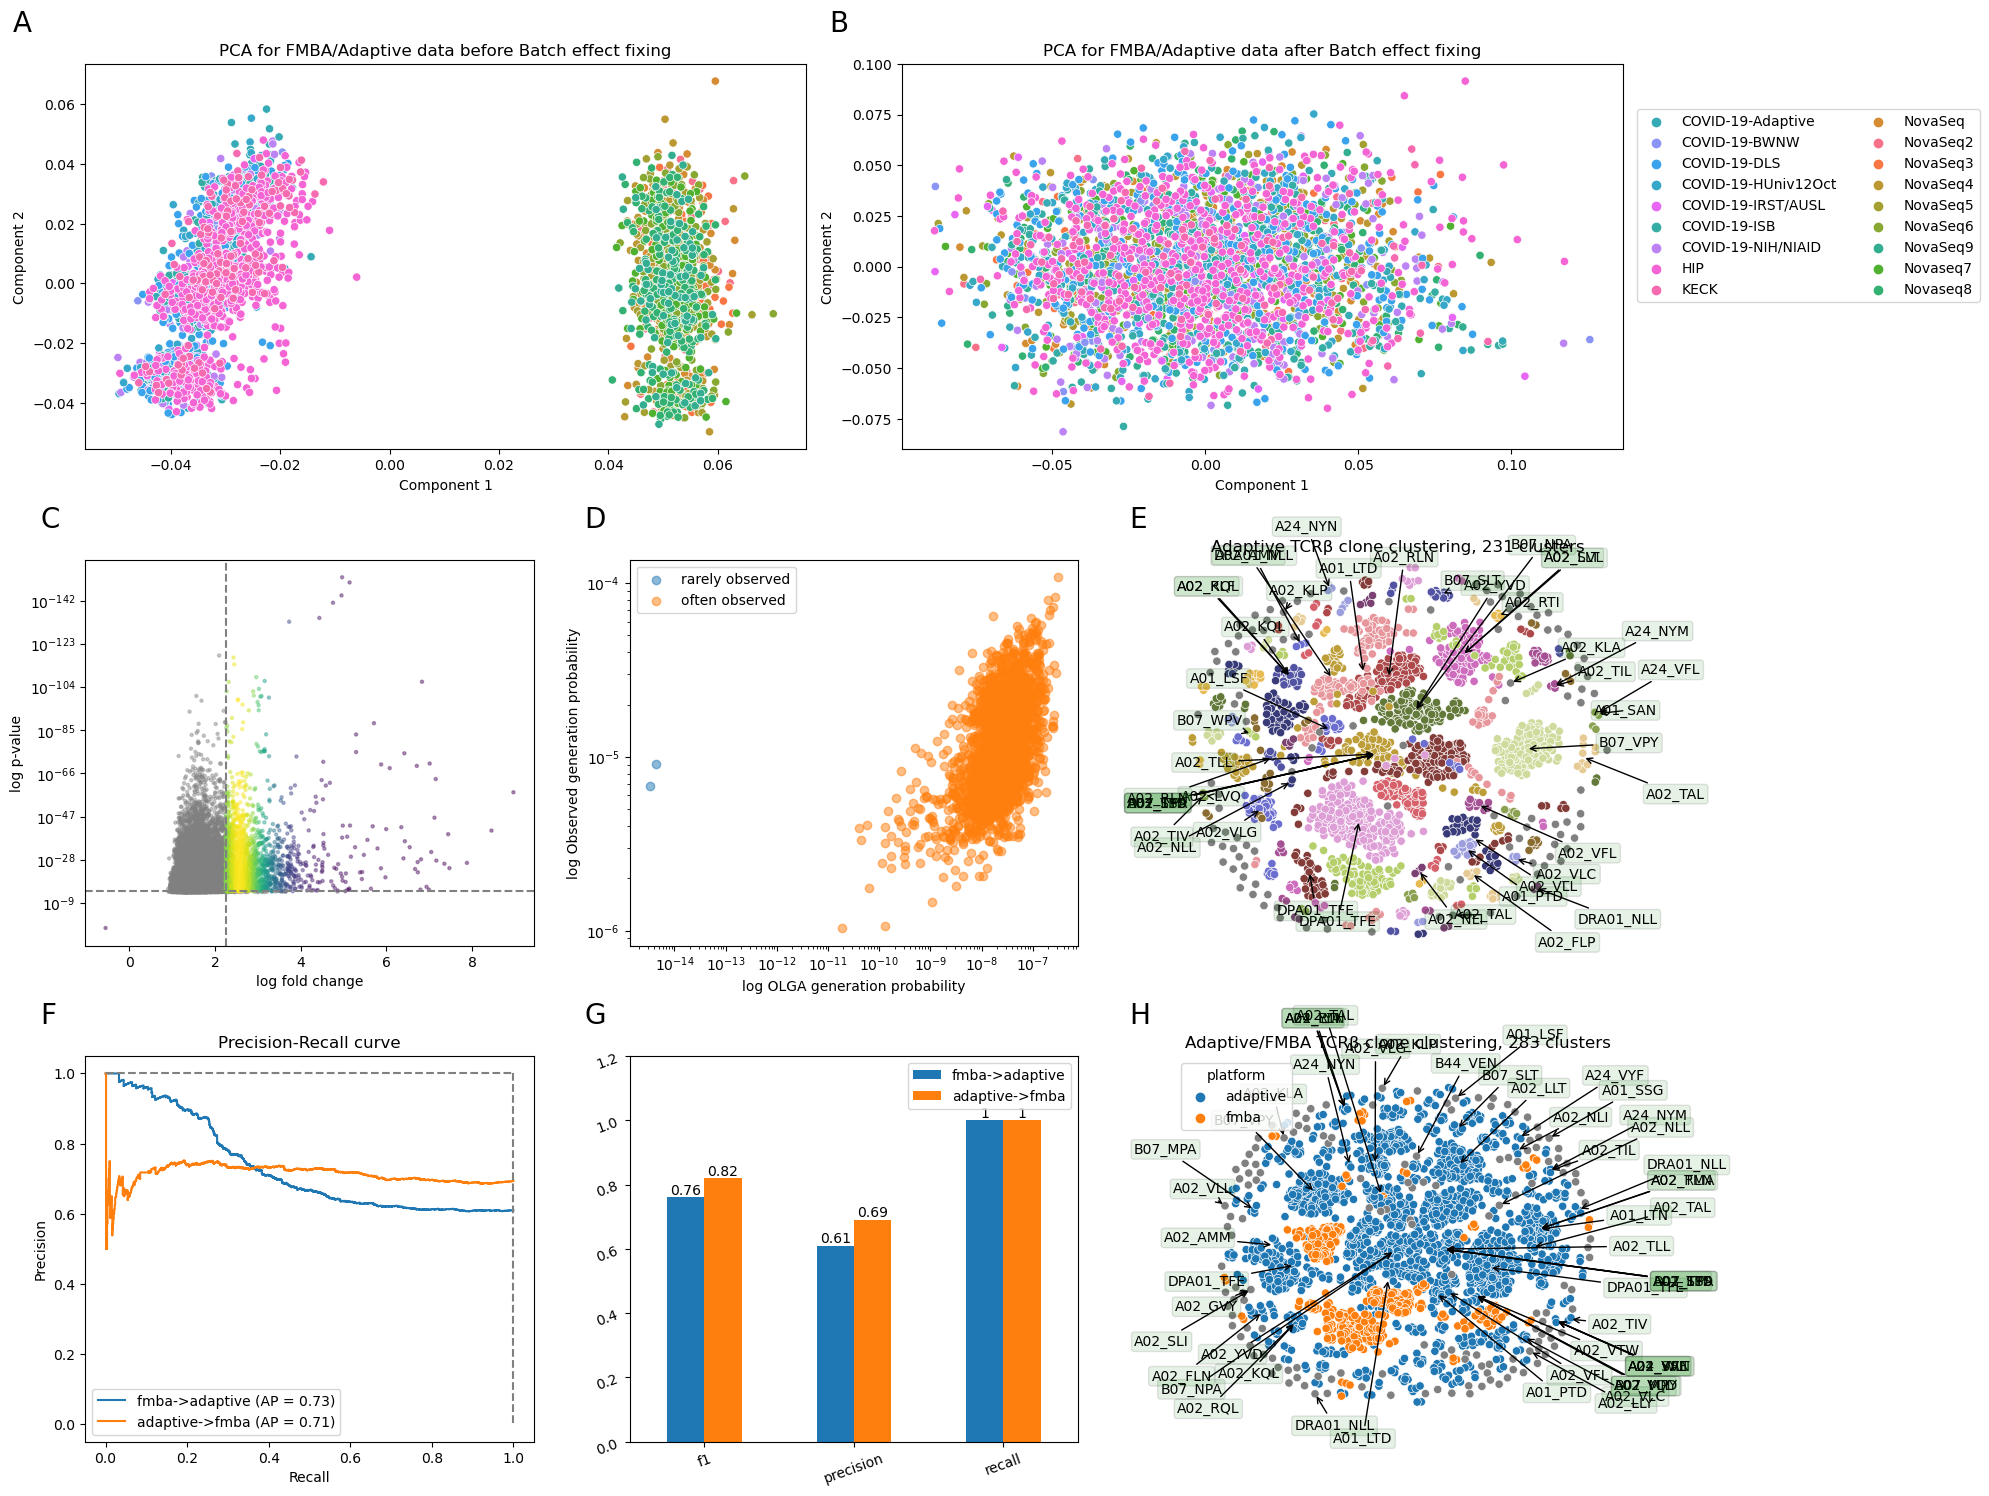

In [73]:
fig = plt.figure(figsize=(20, 15))
gs = GridSpec(nrows=3, 
              ncols=6)
font_size=20
delta_x=-0.1
delta_y=1.14

########################################################
ax0 = fig.add_subplot(gs[0, :3])

plot_usage_matrix_pca(norm_um_joint, method=PCA, target='project', ax=ax0)

ax0.legend()
ax0.set_title('PCA for FMBA/Adaptive data before Batch effect fixing')
ax0.text(delta_x, delta_y, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax0.transAxes,
        size=font_size)
ax0.legend([],[], frameon=False)

########################################################
ax1 = fig.add_subplot(gs[0, 3:])

plot_usage_matrix_pca(stand_um_joint, method=PCA, target='project', ax=ax1)

ax1.legend()
ax1.set_title('PCA for FMBA/Adaptive data after Batch effect fixing')
ax1.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)
handles, labels = ax1.get_legend_handles_labels()
pairs = [(x, y) for x, y in zip(handles, labels)]
pairs.sort(key=lambda x: x[1])

leg = ax1.legend([x[0] for x in pairs], [x[1] for x in pairs], ncol=2, bbox_to_anchor=(1.01, 0.9)) 

# sns.move_legend(ax1, "upper right", bbox_to_anchor=(1.15, 1.1))
########################################################

ax3 = fig.add_subplot(gs[1, :2])
plot_volcano(fold_change_data_adaptive, pval_threshold=1e-14, fold_change_threshold=2.25, ax=ax3)
ax3.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)
ax3.set_ylabel('log p-value')

########################################################

ax4 = fig.add_subplot(gs[1, 2:4])
plot_olga_cleanup_data(probas_adaptive, observed_threshold=1e-6, gen_threshold=1e-12, ax=ax4)
ax4.text(delta_x, delta_y, 'D',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax4.transAxes,
        size=font_size)

########################################################

ax5 = fig.add_subplot(gs[1, 4:])


plot_clonotype_clustering_with_epitope_labeling(res_adaptive, 
                                                adaptive_cluster_to_epi, 
                                                vdjdb, 
                                                gene='TRB', 
                                                cluster_size_threshold=0, 
                                                dist_to_center=850, 
                                                center_diff_threshold=75,
                                                species_to_plot=['SARS-CoV-2'],
                                                ax=ax5)
ax5.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)
ax5.set_title(f'Adaptive TCRβ clone clustering, {res_adaptive.cluster.max() + 1} clusters')
ax5.axis('off')
ax5.set_xlim(-950, 950)
ax5.set_ylim(-950, 950)
ax5.legend([],[], frameon=False)

########################################################

ax6 = fig.add_subplot(gs[2, :2])

for key in ['fmba->adaptive', 'adaptive->fmba']:
    PrecisionRecallDisplay.from_estimator(
        all_clfs[key], X_test_data[key], y_test_data[key], name=key, ax=ax6
    )
    # fpr, tpr, _ = roc_curve(y_test_data[key], all_clfs[key].predict_proba(X_test_data[key])[::,1])
    # ax6.plot(fpr,tpr, label=key)

ax6.set_ylabel('Precision')
ax6.set_xlabel('Recall')
ax6.plot([0, 1], [1, 1], linestyle='dashed', color='grey')
ax6.plot([1, 1], [1, 0], linestyle='dashed', color='grey')
ax6.legend()
ax6.set_title('Precision-Recall curve')
ax6.text(delta_x, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax6.transAxes,
        size=font_size)


########################################################

ax2 = fig.add_subplot(gs[2, 2:4])

metrics.T.plot.bar(ax=ax2)
for c in ax2.containers:
    ax2.bar_label(c, label_type='edge')
ax2.set_ylim(0, 1.2)
ax2.tick_params(labelrotation=20)
ax2.text(delta_x, delta_y, 'G',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)
########################################################

ax5 = fig.add_subplot(gs[2, 4:])
plot_clonotype_clustering_with_epitope_labeling(res_joint, 
                                                joint_cluster_to_epi, 
                                                vdjdb, 
                                                gene='TRB',
                                                color_by='platform',
                                                cluster_size_threshold=0, 
                                                dist_to_center=1050, 
                                                center_diff_threshold=100,
                                                ax=ax5,
                                                species_to_plot=['SARS-CoV-2'])
ax5.set_xlim(-1100, 1100)
ax5.set_ylim(-1100, 1100)
ax5.text(delta_x, delta_y, 'H',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)
ax5.axis('off')
ax5.set_title(f'Adaptive/FMBA TCRβ clone clustering, {res_joint.cluster.max() + 1} clusters')

########################################################

plt.tight_layout()
plt.savefig("figures/fig5.svg")
plt.savefig("figures/fig5.pdf")
plt.savefig("figures/fig5.png")
plt.show()
